In [40]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import glob

#this is for Sven Buder's fits file reader function which reads fits into a Python dict of numpy arrays

In [41]:
from spectres import spectres
#these are for running spectres which allows us to resample spectra and their errors with very little effort 

In [42]:
#sobject_ids = [161217002601184,170418003701205] 
#sobject_ids = [170418003701205] 
import pandas as pd 


df_full= pd.read_csv("/home/praveen/Dropbox/Masters/python-code/galah-file-read-test/data/GALAH_all_sobject_ids.csv") #full GALAH catalog

df_missing = pd.read_csv("/home/praveen/Dropbox/Masters/python-code/galah-file-read-test/data/GALAH_DR3_list_missing_normalized_spectra_v2.csv", header=None) #GALAH objects with missing normalised spectra 
df_full.drop(['Unnamed: 0'], axis=1)
df_missing.columns = ['sobject_id']

df_temp = pd.merge(df_full, df_missing, how='outer', indicator=True)
df_final_sobject_ids_temp = df_temp.loc[df_temp['_merge'] == "left_only"].drop(["Unnamed: 0","_merge"], axis=1)

np.random.seed(1) #set seed here 
sobject_ids = df_final_sobject_ids_temp.loc[np.random.choice(df_final_sobject_ids_temp.index, size=100)]["sobject_id"].to_numpy().tolist()

#input the object IDs, change this later to handle a list of 30K object IDs
#these object IDs will drive the read_spectra method
#calling read_spectra using object IDs in a loop will be useful to iterate through all the objects and generate dict() objects for their spectra 

In [43]:
print(sobject_ids) #test selection

[160514003801280, 151229004001399, 170417005001030, 151229003501228, 140707003101314, 170725003601221, 160423002701289, 170513003501233, 170806001601060, 140810005901113, 150827004601212, 140310002101365, 161007002301320, 160108003101298, 170513004001209, 161013005401394, 150429004102015, 150703004601348, 170217002201161, 190224003201236, 161210003401186, 170909003201016, 140310003801049, 140810003201361, 160529003401309, 170515004101292, 170412004401241, 171031004502306, 160403003601131, 160423002701263, 140707000601132, 160515002801289, 170202001202342, 161219004101010, 170106005101218, 170711004501282, 170410004501112, 140814004801249, 160531005101380, 160403005201054, 150204001601298, 161104002301196, 140413005401145, 140611003501287, 160518001401080, 151111002101060, 170516001101336, 181222001801157, 141101003501253, 140711003901341, 160327003601360, 170506006401166, 181222004101116, 150901000601037, 150607003101299, 150207002101285, 141231002501334, 151220002801224, 1605310061010

In [44]:
GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740

#the grid size was determined by looking at camera 3 for a few fits files and checking the step between lambda values that are general enough for all fits files 
#lower and upper limites are from Sven Buder's example for camera 3
#this constants will have to be adjusted depending on the element being studied and the minimum resolution of the wave grid (lambda values i.e. lambda[i+1] - lambda[i])

In [45]:
regrid = np.arange(LOWER_LAMBDA, UPPER_LAMBDA, GRID_SIZE) 

#this is the grid onto which spectres will resampple 

In [46]:
def read_spectra(sobject_id):
    fits_files = [[],[],[],[]]
    for each_ccd in [1,2,3,4]:
        fits_files[each_ccd-1] = glob.glob("/home/praveen/Dropbox/Masters/python-code/galah-file-read-test/data/GALAH_DR3/spectra/SPECTRA/"+str(sobject_id)+str(each_ccd)+".fits") #this is reading fits files from file and not downloading directly 

    spectrum = dict()
    for each_ccd in [1,2,3,4]: #GALAH uses indexing from 1 - 4
        if fits_files[each_ccd-1]!=[]: #just using zero indexing here 
            fits = pyfits.open(fits_files[each_ccd-1][0]) 
            
            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the reduced spectrum 

            # Extract wavelength grid for the normalised spectrum
            start_wavelength = fits[4].header["CRVAL1"]
            dispersion       = fits[4].header["CDELT1"]
            nr_pixels        = fits[4].header["NAXIS1"]
            reference_pixel  = fits[4].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel=1
            spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the normalised spectrum 

            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data)
            spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
            if each_ccd != 4:
                spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
            else:
                # for normalised error of CCD4, only used appropriate parts of error spectrum
                spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))

    return spectrum 
    
    #returns a 30 "row" dict of numpy array per row 'wave_red_x' is the key for the key value pair
    #camera 3 will be the more useful canmera for Li spectra 

In [47]:
def resample_spectra(spectrum, camera, verbose):

    spec_resample, spec_errs_resample = spectres(regrid,  spectrum['wave_norm_'+str(camera)], spectrum['sob_norm_'+str(camera)], spec_errs= spectrum['uob_norm_'+str(camera)],verbose=verbose) 

    return spec_resample, spec_errs_resample

#for Li pick camera 3

In [48]:
#open an empty dict to store the results 
resampled_spectra_collection = {}
resampled_spectra_collection['spec_resample'] = []

resampled_error_collection = {}
resampled_error_collection['error_resample'] = []

In [51]:
for sobject_id in sobject_ids:
    #this is the normalised resampled spectra 
    temp_spectrum = resample_spectra(read_spectra(sobject_id), 3, False)
    temp_spectrum[0][np.isnan(temp_spectrum[0])] = 1 #padding 
    resampled_spectra_collection['spec_resample'].append(temp_spectrum[0])

    #these are the error spectra
    #calculate mean error for padding 

    non_na_values = temp_spectrum[1][~np.isnan(temp_spectrum[1])]
    mean_error = np.mean(non_na_values)

    temp_spectrum[1][np.isnan(temp_spectrum[1])] = mean_error
    resampled_error_collection['error_resample'].append(temp_spectrum[1])

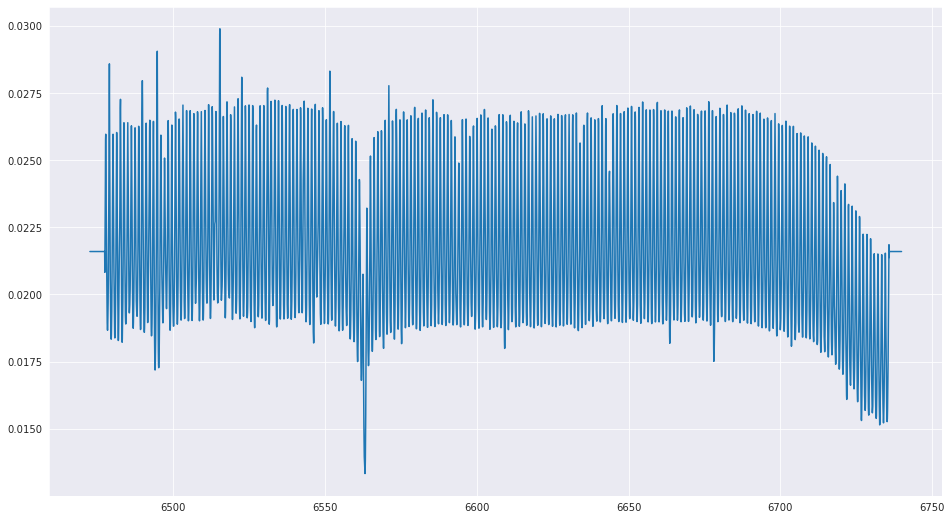

In [55]:
plt.plot(regrid, resampled_error_collection['error_resample'][99]) #testing if the error padding works 

In [56]:
# making the plots look good 
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('darkgrid')

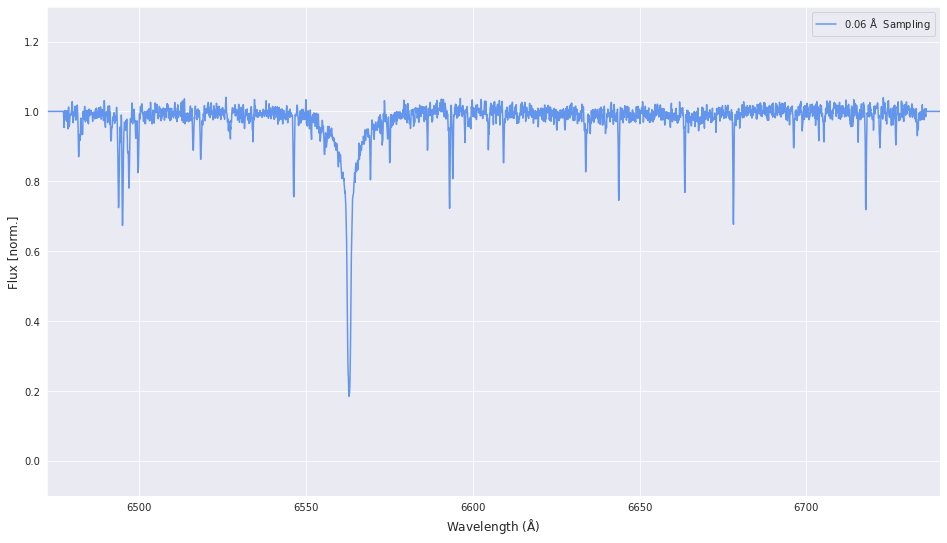

In [57]:
#test one spectrum 
f, ax = plt.subplots(figsize=(16,9))
ax.plot(regrid, resampled_spectra_collection['spec_resample'][99], color="cornflowerblue", lw=1.5, label=str(GRID_SIZE)+" $\mathrm{\AA}\ $ Sampling")
ax.set_xlabel("Wavelength ($\mathrm{\AA}$)", size=12)
ax.set_ylabel("Flux [norm.]", size=12)
ax.set_ylim(-0.1,1.3) # turn this into an input 
ax.set_xlim(LOWER_LAMBDA, UPPER_LAMBDA)
ax.legend()
plt.show()

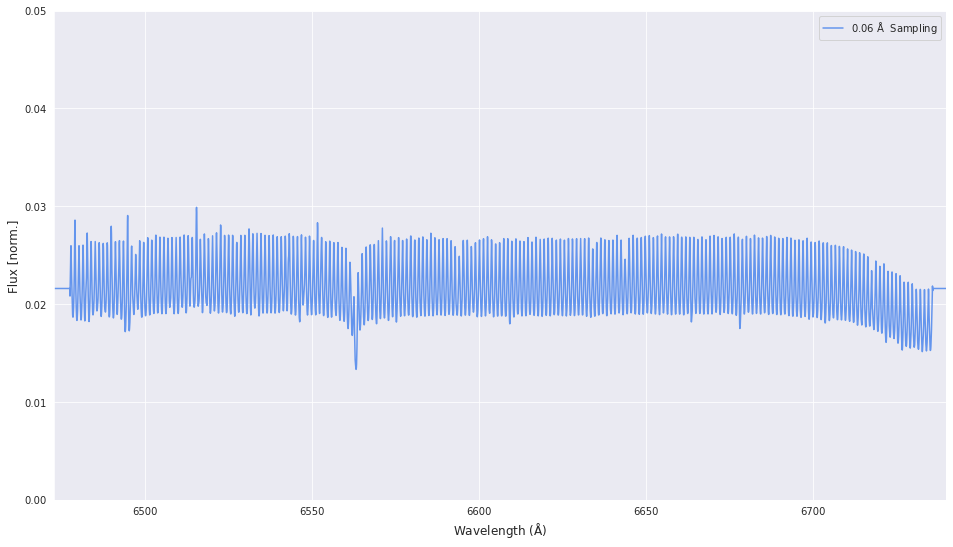

In [62]:
#test one error 
f, ax = plt.subplots(figsize=(16,9))
ax.plot(regrid, resampled_error_collection['error_resample'][99], color="cornflowerblue", lw=1.5, label=str(GRID_SIZE)+" $\mathrm{\AA}\ $ Sampling")
ax.set_xlabel("Wavelength ($\mathrm{\AA}$)", size=12)
ax.set_ylabel("Flux [norm.]", size=12)
ax.set_ylim(0,0.05) # turn this into an input 
ax.set_xlim(LOWER_LAMBDA, UPPER_LAMBDA)
ax.legend()
plt.show()

In [64]:
import h5py

#save the resampled spectra to be used as inputs to the training set
hf_spec = h5py.File("resampled_training_spectra.h5", "w")
hf_spec.create_dataset('spectra', data=resampled_spectra_collection['spec_resample'])
hf_spec.close()

In [65]:
#save the wavelength grid 
hf_grid = h5py.File("wl_grid.h5", "w")
hf_grid.create_dataset('wl_grid', data=regrid)
hf_grid.close()

In [66]:
#save the error spectra
hf_error = h5py.File("resampled_training_errors.h5", "w")
hf_error.create_dataset('errors', data=resampled_error_collection['error_resample'])
hf_error.close()

Prep a sample test dataset

In [ ]:
def resample_spectra2(spectrum, camera, verbose):

    spec_resample, spec_errs_resample = spectres(regrid,  spectrum['wave_norm_'+str(camera)], spectrum['sob_norm_'+str(camera)], spec_errs= spectrum['uob_norm_'+str(camera)],verbose=verbose) 

    return spec_resample, spec_errs_resample

#for Li pick camera 3

In [ ]:
def read_spectra2(sobject_id):
    fits_files = [[],[],[],[]]
    for each_ccd in [1,2,3,4]:
        fits_files[each_ccd-1] = glob.glob('C:/Users/Praveen Jayasuriya/Dropbox/masters/python-code/galah-file-read-test/data/Test_spectra/'+str(sobject_id)+str(each_ccd)+'.fits') #this is reading fits files from file and not downloading directly 

    spectrum = dict()
    for each_ccd in [1,2,3,4]: #GALAH uses indexing from 1 - 4
        if fits_files[each_ccd-1]!=[]: #just using zero indexing here 
            fits = pyfits.open(fits_files[each_ccd-1][0]) 
            
            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the reduced spectrum 

            # Extract wavelength grid for the normalised spectrum
            start_wavelength = fits[4].header["CRVAL1"]
            dispersion       = fits[4].header["CDELT1"]
            nr_pixels        = fits[4].header["NAXIS1"]
            reference_pixel  = fits[4].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel=1
            spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the normalised spectrum 

            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data)
            spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
            if each_ccd != 4:
                spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
            else:
                # for normalised error of CCD4, only used appropriate parts of error spectrum
                spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))

    return spectrum 
    
    #returns a 30 "row" dict of numpy array per row 'wave_red_x' is the key for the key value pair
    #camera 3 will be the more useful canmera for Li spectra 

In [ ]:
sobject_ids = [181226004101187] #test spectrum

In [ ]:
#open an empty dict to store the results 
resampled_spectra_collection2 = {}
resampled_spectra_collection2['spec_resample'] = []

In [ ]:
resampled_spectra_collection_ivar_2 = {}
resampled_spectra_collection_ivar_2['ivar'] = []

In [ ]:
for sobject_id in sobject_ids:
    spectrum = read_spectra2(sobject_id)
    temp_spectrum, temp_ivar = resample_spectra2(spectrum, 3, False)
    temp_spectrum[np.isnan(temp_spectrum)] = 1
    temp_ivar[np.isnan(temp_ivar)] = 0.02
    resampled_spectra_collection2['spec_resample'].append(temp_spectrum)
    resampled_spectra_collection_ivar_2['ivar'].append(temp_ivar)

#the loop apends each resampled spectrum to a dictionary data structure 
#turn verbose off for function resample_spectrum by modifying spectres function 

In [ ]:
resampled_spectra_collection_ivar_2['ivar']

In [ ]:
plt.plot(regrid, resampled_spectra_collection_ivar_2["ivar"][0])

In [ ]:
plt.plot(regrid, resampled_spectra_collection2['spec_resample'][0])

In [ ]:
import h5py

#save the resampled spectra to be used as inputs to the training set
test_spectrum = h5py.File("test_spectrum.h5", "w")
test_spectrum.create_dataset('test_spectrum', data=resampled_spectra_collection2['spec_resample'])
test_spectrum.close()

In [ ]:
test_ivar = h5py.File("test_ivar.h5", "w")
test_ivar.create_dataset('test_ivar', data=resampled_spectra_collection_ivar_2["ivar"])
test_ivar.close()